# Homework 1：簡易手寫數字辨識
助教email:　boxunwen2001@gmail.com

在這個notebook中，有許多的 TODO 需要你填寫。
1. 調整適當的參數
2. 試著畫出每一個類別的樣本數量，填寫 yaxis=
3. 寫出當 mode = valid、test 的 getitem()
4. 將所看到的空格都填滿，總共要填三個部分: range()、reshape(, )、axes[ , ]
5. 建立自己喜歡的 model 架構
6. 嘗試去計算 misclassification_rate
7. 助教挖掉了一小部分，請你讓它可以運作起來。
8. split the training dataset in a 80: 20，填寫 train_size= , test_size= 。
9. val_dataset = 
10. 調整適當的 optimizer、scheduler，不調也可以，但排名不容許你這樣做。
11. 畫出 train 跟 valid 的 Misclassification Rate 圖。
12. 在 testing 這個 def 填空格。
13. 填寫test_data、test_dataset、test_loader、model 四個空格。
14. 為輸出的 csv 檔命名。

In [1]:
# For data loading and scientific computing
import pandas as pd
import numpy as np
import random
import os
import csv

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Deep learning framework
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
import torch.nn as nn

# data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

2.4.1+cu118
11.8
90100
True


## Configuration

In [2]:
# TODO_1: 調整適當的參數
class config:
    root = "Users\mikai\OneDrive\Desktop\MIA\hw1"
    batch_size = 64      # 通常是2的倍數
    lr = 1e-3            # 通常是10的倍數，1e-8 = 10^-8
    epochs = 50           # 看你心情要設多少
    weight_decay = 0.01  #對loss funtion的懲罰項，模型越複雜，loss會越大，有防止overfitting的用意。
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42            # 看你心情要設多少

## Utils

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True  #True:確保相同輸入有相同輸出
    torch.backends.cudnn.benchmark = False     #True:自動尋找最佳算法，提升運算效率，但這裡我們設成 False 。

## EDA

從下面的 dataframe 可以看出，第一個 column 表示 image_id ，第二個 column 表示每個樣本的類別，剩餘 256 個 columns 表示影像的灰階 pixel values

In [4]:
# Read in the dataframe
train_data = pd.read_csv('zip.train.csv', header=None)
test_data = pd.read_csv('zip.test.csv', header=None)
print(train_data)

        0    1    2    3    4      5      6      7      8      9    ...  \
0        A1    6 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.631  ...   
1        A2    5 -1.0 -1.0 -1.0 -0.813 -0.671 -0.809 -0.887 -0.671  ...   
2        A3    4 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
3        A4    7 -1.0 -1.0 -1.0 -1.000 -1.000 -0.273  0.684  0.960  ...   
4        A5    3 -1.0 -1.0 -1.0 -1.000 -1.000 -0.928 -0.204  0.751  ...   
...     ...  ...  ...  ...  ...    ...    ...    ...    ...    ...  ...   
7286  A7287    3 -1.0 -1.0 -1.0 -0.988 -0.527 -0.208  0.620  1.000  ...   
7287  A7288    3 -1.0 -1.0 -1.0 -0.990  0.708  0.557  0.347 -0.107  ...   
7288  A7289    3 -1.0 -1.0 -1.0 -0.783 -0.984 -0.827  0.068  1.000  ...   
7289  A7290    0 -1.0 -1.0 -1.0 -1.000 -1.000 -0.549  0.463  0.999  ...   
7290  A7291    1 -1.0 -1.0 -1.0 -1.000 -1.000 -0.108  1.000  0.616  ...   

        248    249    250    251    252    253    254    255    256  257  
0     0.304  0.823  1.00

In [5]:
train_data.iloc[:, 2:].describe() #總結資料集分佈的集中趨勢、離散度和形狀（不包括 NaN值）

,2,3,4,5,6,7,8,9,10,11,...,248,249,250,251,252,253,254,255,256,257
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,-0.284564,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,0.746838,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,-1.000000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,-0.561000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,0.438000,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


In [6]:
print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of testing samples: {test_data.shape[0]}")

Number of training samples: 7291
Number of testing samples: 2007


In [7]:
train_data.iloc[:, 1].value_counts().sort_index() #計算train_data標籤數量

1
0    1194
1    1005
2     731
3     658
4     652
5     556
6     664
7     645
8     542
9     644
Name: count, dtype: int64

## Show the number of images in each digit for the training dataset (2 pts)

In [8]:
train_label_distribution = train_data.iloc[:, 1].value_counts().sort_index()
train_label_distribution = pd.DataFrame(
    {
        "labels": train_label_distribution.index.astype(str), #將int64改成str
        "number_of_samples": train_label_distribution.values
    }
)

# TODO_2: 試著畫出每一個類別的樣本數量，填寫 yaxis=

#以下兩個是視覺化參數設定
fig = px.bar(
    train_label_distribution, x="labels", y="number_of_samples",
    labels=dict(y="number of samples"),
)
# update_layout 用來更新圖表的佈局配置，調整圖表的外觀和樣式
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show x-axis grid，zeroline=False為不顯示x=0那條線
    yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show y-axis grid，zeroline=False為不顯示y=0那條線
    title=dict(text="Number of Samples Per Labels", x=0.5, y=0.975, font=dict(size=20))
)
fig.show()

## Pytorch Dataset

pytorch dataset 必須為自定義物件，且須繼承於 `torch.utils.data.Dataset`。我們必須實現下列方法

- `__init__:` Initialization Setting
- `__len__:` return the length of the data
- `__getitem__:` return the data according to the index draw from sampler

Pandas 的 DataFrame 這種資料結構適合處理表格，但不適合用在DL當中，因為他不支援 GPU 運算跟自動微分的功能

所以，我們要轉成 torch.tensor ，專門為DL所設計的框架，支援上述所提及的功能。

但 Pandas 和 PyTorch 會有兼容性問題，有些複雜的資料結構會出意外，在這種情況下，我們會先轉成NumPy來確保相容。

In [9]:
class HandwrittenDigits(torch.utils.data.Dataset):
    def __init__(self, df, mode = None, transforms=None):
        self.df = df
        self.transforms = transforms #之後的作業會用到
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, x):
        if self.mode == "train":
            ID = self.df.iloc[x, 0]                                 #抓取第 x 筆資料，第 0 欄為 image_id。
            label = self.df.iloc[x, 1]                              #抓取第 x 筆資料，第 1 欄為 image_label。
            image = self.df.iloc[x, 2:].to_numpy(dtype=np.float32)  #抓取第 x 筆資料，第 2 欄為 image 的 pixel。
            label, image = torch.tensor(label), torch.tensor(image)
            
            if self.transforms: #這個只會用在 train_data 身上，所以 valid_data 不用。
                transformed = self.transforms(image=image)
                image = transformed['image']
                
            return ID, label, image
        
        # TODO_3: 寫出當 mode = valid、test 的 getitem()
        elif self.mode == "valid":
            ID = self.df.iloc[x, 0] 
            label = self.df.iloc[x, 1]  
            image = self.df.iloc[x, 2:].to_numpy(dtype=np.float32)
            label, image = torch.tensor(label), torch.tensor(image)
            
            return ID, label, image
        
        elif self.mode == "test":
            ID = self.df.iloc[x, 0] 
            image = self.df.iloc[x, 1:].to_numpy(dtype=np.float32)
            image = torch.tensor(image)
            
            return ID, image  # 因為 test 沒 label

In [10]:
ds = HandwrittenDigits(train_data, mode = "train")
ds[0]

('A1',
 tensor(6),
 tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6310,
          0.8620, -0.1670, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9920,  0.2970,
          1.0000,  0.3070, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.4100,  1.0000,
          0.9860, -0.5650, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6830,  0.8250,  1.0000,
          0.5620, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9380,  0.5400,  1.0000,  0.7780,
         -0.7150, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,  0.1000,  1.0000,  0.9220, -0.4390,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         

## Pytorch DataLoader

怎麼讓neural network 批次(batch)讀取影像資料呢? 我們可以透過 pytorch dataloader 來達成，pytorch dataloader 包含三個部分

- sampler: 抽樣方式，主要是生出一組index。

常見的抽樣方式包括：

SequentialSampler: 順序抽樣，按照順序抽取資料。

RandomSampler: 隨機抽樣，隨機抽取資料。

SubsetRandomSampler: 從一個subset隨機抽樣。

- dataset: 對影像的處理方法，根據這組index提取相對應的資料。

我們有自定義HandwrittenDigits，__getitem()__定義了如何讀取 image 與 label 。

- collate_fn: 對一個batch進行整合。

Batch 是指在一次迭代（iteration）中， model 處理的資料樣本的數量。

例如，1000個樣本，我可以設定每次迭代中使用 batch=32 (每次訓練都用32個樣本)。

使用 Batch 可以在訓練過程中讓 gradient descent 更穩定、更平滑的更新，對於大型資料集可以避免一次性加載所有數據導致內存不足。

具體流程如下:
sampler --> indices --> dataset --> collate_fn

視覺化詳見 [https://twitter.com/_ScottCondron/status/1363494433715552259](https://twitter.com/_ScottCondron/status/1363494433715552259)

In [11]:
# train_data = pd.read_csv(os.path.join(config.root, 'zip.train.csv'), header=None)
train_data = pd.read_csv('zip.train.csv', header=None)
train_dataset = HandwrittenDigits(train_data, mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True) #shuffle=True代表使用 RandomSampler。

## For each digit, plot 10 randomly selected images from your training dataset. (4 pts)

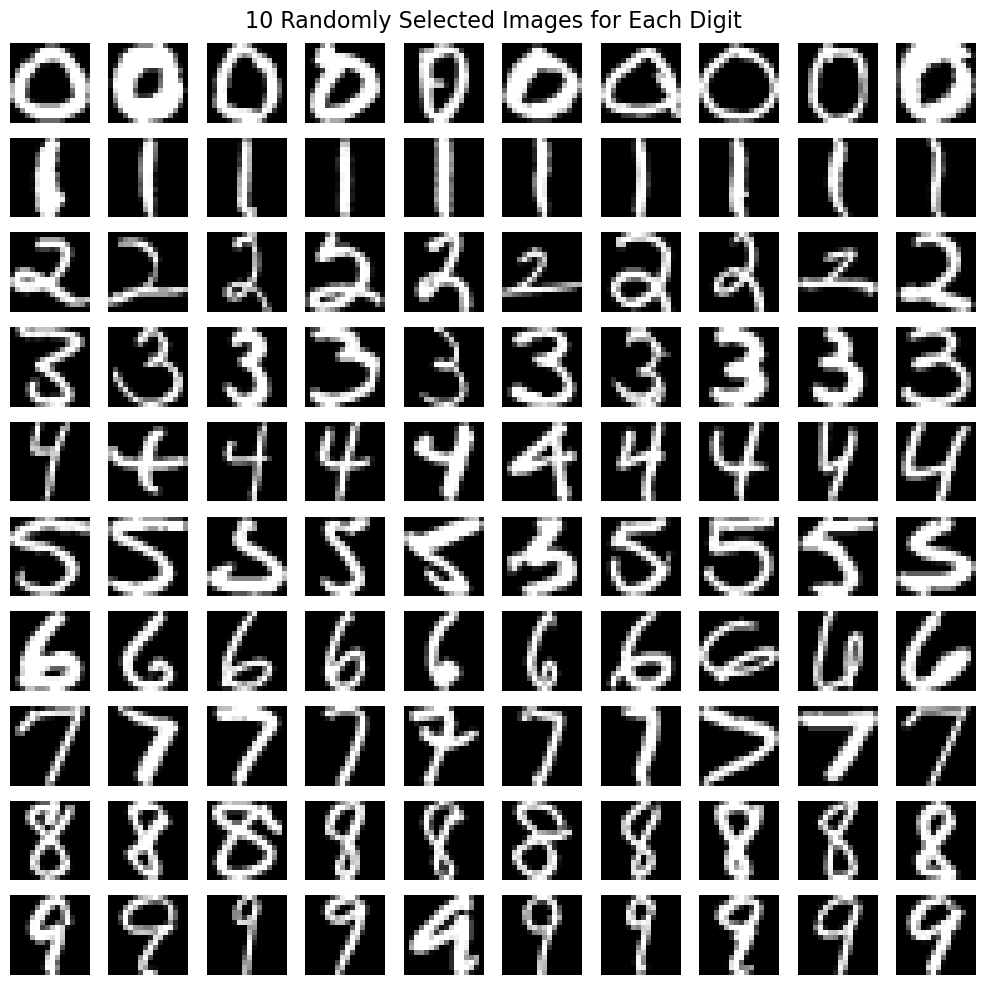

In [12]:
# TODO_4: 將所看到的空格都填滿，總共要填三個部分: range()、reshape(, )、axes[ , ]

# 建立字典用來儲存 0~9 的圖像
digit_images = {i: [] for i in range(10)} # range()裡面要填數字

# 從train_dataset抓取 label 跟 image，並將 image 重塑成 16x16，放進字典中。
for ID, label, image in train_dataset:
    digit_images[label.item()].append(image.numpy().reshape(16, 16)) # reshape( , )裡面要填兩個數字

# 繪製每個數字的隨機10張圖片
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.suptitle('10 Randomly Selected Images for Each Digit', fontsize=16)

for digit in range(10):
    # 隨機選擇10張圖片
    selected_images = random.sample(digit_images[digit], 10)
    for i, img in enumerate(selected_images):
        ax = axes[digit, i]                                   #axes 是一個 10x10 的 matplotlib 子圖， 其[ , ]要填兩個變數來鎖定子圖位子
        ax.imshow(img, cmap='gray')
        ax.axis('off')

plt.tight_layout() #自動調整圖片間距，避免圖像太過緊密。
plt.show()

# Pytorch Module

Pytorch neural network 同樣也是需自定義的物件，我們必須實現兩種方法

- `__init__:` model 的初始化函數，用於定義模型的結構
- `forward:` 定義了 model 向前傳播的過程

這裡示範 Net-2: Two hidden layers with 64 and 16 nodes, respectively

In [13]:
# TODO_5: 建立自己喜歡的 model 架構
# 這裡不需要有 softmax，因為之後的 nn.CrossEntropyLoss()隱含了一個 softmax ，如果在這裡加 softmax，你會套用到兩次。
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Increase units to 256 for better feature extraction
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization after first layer
        self.relu = nn.ReLU()  # ReLU activation
        
        self.fc2 = nn.Linear(256, 128)  # Second fully connected layer with 128 units
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization after second layer
        
        self.fc3 = nn.Linear(128, 64)  # Third layer with 64 units
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization
        
        self.dropout = nn.Dropout(0.5)  # Dropout to reduce overfitting
        
        self.final_fc = nn.Linear(64, output_dim)  # Final output layer
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply batch normalization
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.bn3(x)  # Batch normalization
        x = self.relu(x)
        
        x = self.dropout(x)  # Apply dropout
        
        x = self.final_fc(x)  # Output layer (no softmax because CrossEntropyLoss will handle it)
        return x

In [14]:
input_dim =  256 # image 的 pixel 有 256
output_dim = 10  # 我們想要分類 0~9 其中一個類別

model = SimpleNN(input_dim, output_dim)
model

SimpleNN(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (final_fc): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
myparameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
myparameter

108490

## Evaluator

In [16]:
# TODO_6: 嘗試去計算 misclassification_rate 
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds # 將 Tensor 轉成 numpy ，如果是 Tensor 的話
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    
    acc = accuracy_score(preds, gts)             # 計算正確率
    f1 = f1_score(preds, gts, average="macro")   # F1 score，介在 0~1 ，對 model 分類性能的綜合評價，越高越好
    misclassification_rate = 1-acc                    # 計算分錯率
    
    return acc, f1, misclassification_rate

# Training

In [17]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()                                            # PyTorch 中一個用來告知 model 進行訓練的狀態設置，會啟用一些用在訓練的層（如 dropout 和 batch normalization）
    train_loss = .0                                          # 累積一個 epoch 的總損失
    predictions, ground_truths = [], []                      # 儲存所有的預測結果和對應的真實標籤。
    for ID, labels, images in train_loader:
        labels = labels.to(device=device, dtype=torch.long)  # nn.CrossEntropyLoss 要求 label 必須是長整數型態，一般的 int 不行。
        images = images.to(device=device, dtype=torch.float) # 將 image 移動到指定的設備（例如 GPU）上，並確保其資料型態為 float。
        
        optimizer.zero_grad()                                # 清空 optimizer 的梯度，避免梯度累加
        logits = model(images)                               # 將 image 輸入 model ，計算輸出的 logits。
        loss = criterion(logits, labels)                     # 計算 model 輸出與真實標籤之間的損失（loss）
        loss.backward()                                      # 計算 loss 對 model 參數的梯度
        
        optimizer.step()                                     # 更新 model 參數
        
        train_loss += loss.item()                            # 將當前 batch 的損失累加到總損失中。
        preds = torch.argmax(logits, dim=1)                  # 獲取機率最大的類別，當作預測
        
        predictions.append(preds)                            # 新增預測結果
        ground_truths.append(labels)                         # 新增真實標籤
        
    scheduler.step()                                         # 更新 lr 的參數，這裡要注意它不是放在 for loop 裡面，因為我們是算完一個 ep 才記一次 lr 。
    
    train_loss /= len(train_loader)                          # 計算整個 epoch 的平均損失
    
    predictions = torch.cat(predictions)                     # 將所有 batch 的預測結果拼成一個完整的張量。
    ground_truths = torch.cat(ground_truths)                 # 將所有的真實標籤拼成一個完整的張量。
    
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths) # 計算當前 epoch 的 acc 、 F1 score 和 misclassification_rate
    
    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass

## Validation

In [18]:
# TODO_7: 助教挖掉了一小部分，請你讓它可以運作起來。
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    predictions, ground_truths = [],[]
    with torch.no_grad(): # 不計算梯度
        for ID, labels, images in valid_loader:
            labels = labels.to(device)
            images = images.to(device)
            
            # validation 不需要計算梯度，所以不用 optimizer 、 loss.backward() 、 scheduler
            logits = model(images)
            loss =  criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())
        
    valid_loss /= len(valid_loader)
    
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)
    
    valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
    
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

In [19]:
def Run():
    
    seed_everything(config.seed)
    device = config.device
    
    train_data = pd.read_csv('zip.train.csv', header=None)
    
    # TODO_8: split the training dataset in a 80: 20，填寫 train_size= , test_size= 。
    train_dataset, val_dataset = train_test_split(train_data, train_size=0.8 , test_size=0.2 , random_state=config.seed)
    
    # TODO_9: val_dataset = 
    train_dataset = HandwrittenDigits(train_dataset, mode = "train")
    val_dataset = HandwrittenDigits(val_dataset, mode="valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    
    model =  SimpleNN(input_dim=256, output_dim=10)
    model.to(device)
    
    # TODO_10: 調整適當的 optimizer、scheduler，不調也可以，但排名不容許你這樣做。
    parameters = [p for p in model.parameters() if p.requires_grad]  # 對 model 的所有參數，抓取那些需要計算梯度的參數用於更新
    # AdamW optimizer with learning rate and weight decay as per the config
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)  
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

    # 參考網站: https://pytorch.org/docs/stable/optim.html
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    # TODO_11: 畫出 train 跟 valid 的 Misclassification Rate 圖。 (4 pts)
    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training Misclassification Rate')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation Misclassification Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate Curves')
    plt.show()

Epoch[1/50], Train Loss: 0.8995, Train Acc: 81.69%, Train F1: 80.12% | Valid Loss: 0.3733, Valid Acc: 95.34%, Valid F1: 94.64%, Valid Misclass: 4.66% | LR: 0.001000
Epoch[2/50], Train Loss: 0.3634, Train Acc: 94.56%, Train F1: 94.00% | Valid Loss: 0.2219, Valid Acc: 96.30%, Valid F1: 95.80%, Valid Misclass: 3.70% | LR: 0.001000
Epoch[3/50], Train Loss: 0.2497, Train Acc: 96.09%, Train F1: 95.70% | Valid Loss: 0.2097, Valid Acc: 94.93%, Valid F1: 94.44%, Valid Misclass: 5.07% | LR: 0.001000
Epoch[4/50], Train Loss: 0.2139, Train Acc: 96.66%, Train F1: 96.34% | Valid Loss: 0.1368, Valid Acc: 97.60%, Valid F1: 97.19%, Valid Misclass: 2.40% | LR: 0.001000
Epoch[5/50], Train Loss: 0.2031, Train Acc: 97.17%, Train F1: 96.90% | Valid Loss: 0.1393, Valid Acc: 97.05%, Valid F1: 96.68%, Valid Misclass: 2.95% | LR: 0.001000
Epoch[6/50], Train Loss: 0.2184, Train Acc: 95.80%, Train F1: 95.45% | Valid Loss: 0.1508, Valid Acc: 96.85%, Valid F1: 96.51%, Valid Misclass: 3.15% | LR: 0.001000
Epoch[7/50

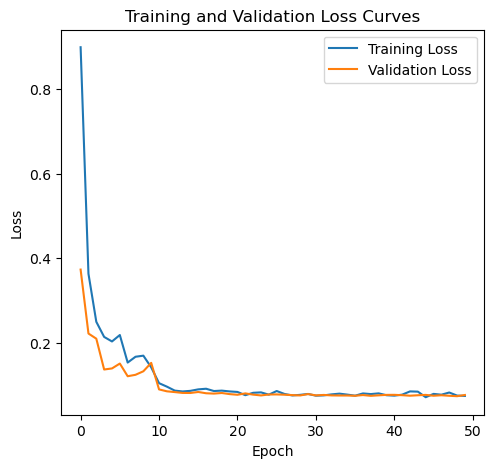

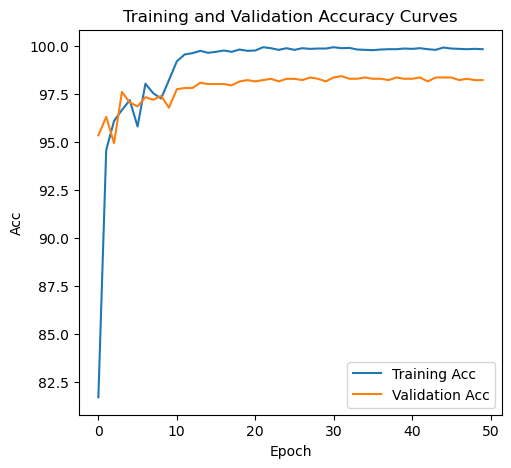

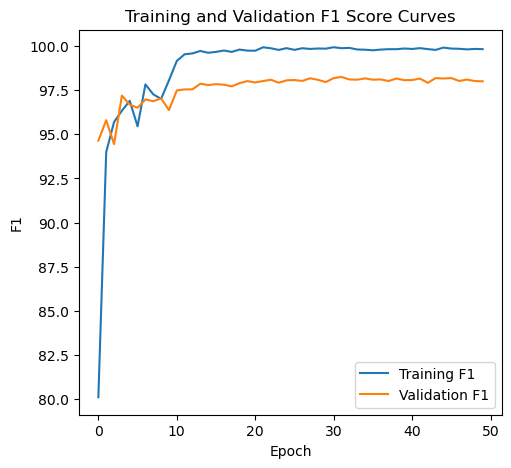

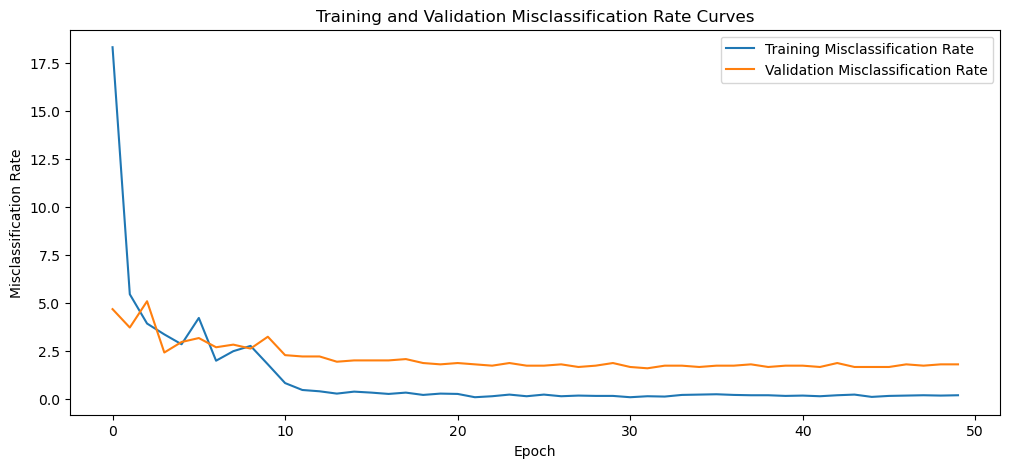

In [20]:
Run()

## testing

In [21]:
# TODO_12: 在 testing 這個 def 填空格。
def testing(model, test_loader, device):
    model.eval()
    all_ids = []
    all_preds = []
    
    with torch.no_grad():
        for ID, images in test_loader:
            images = images.to(device) 
            logits = model(images)
            preds = torch.argmax(logits, dim=1) 
            all_ids.extend(ID)
            all_preds.extend(preds.cpu().numpy())
    
    return all_ids, all_preds

In [22]:
seed_everything(config.seed)
device = config.device

# TODO_13: 填寫test_data、test_dataset、test_loader、model四個空格， Hint: test_loader 的 shuffle=False，不然你會出大事。
test_data = pd.read_csv('zip.test.csv', header=None)
print(test_data)

test_dataset =HandwrittenDigits(test_data, mode="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

model =  SimpleNN(input_dim=256, output_dim=10)
model.to(device)
best_ckpt = torch.load("checkpoint.pth", map_location=device)
model.load_state_dict(best_ckpt["model"])

ids, preds = testing(model, test_loader, device)

        0    1    2    3      4      5      6      7      8      9    ...  \
0        B1 -1.0 -1.0 -1.0 -1.000 -1.000 -0.948 -0.561  0.148  0.384  ...   
1        B2 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
2        B3 -1.0 -1.0 -1.0 -0.593  0.700  1.000  1.000  1.000  1.000  ...   
3        B4 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
4        B5 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.858 -0.106  ...   
...     ...  ...  ...  ...    ...    ...    ...    ...    ...    ...  ...   
2002  B2003 -1.0 -1.0 -1.0 -1.000 -1.000 -0.417  0.814  1.000  0.775  ...   
2003  B2004 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -0.855  0.209  0.941  ...   
2004  B2005 -1.0 -1.0 -1.0 -1.000 -0.031  0.752 -0.431 -1.000 -1.000  ...   
2005  B2006 -1.0 -1.0 -1.0 -1.000 -0.534  0.578  1.000  0.301 -0.328  ...   
2006  B2007 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000  0.399  0.949  ...   

        247    248    249    250    251    252  253  254  255  256  
0    -

In [23]:
# Get predictions
ids, preds = testing(model, test_loader, device)

# Create DataFrame
results_df = pd.DataFrame({
    'ID': ids,
    'Class': preds
})

print(results_df)

# TODO_14: 為輸出的 csv 檔命名。
results_df.to_csv('test_predictions.csv', index=False)

         ID  Class
0        B1      9
1        B2      6
2        B3      3
3        B4      6
4        B5      6
...     ...    ...
2002  B2003      3
2003  B2004      9
2004  B2005      4
2005  B2006      0
2006  B2007      1

[2007 rows x 2 columns]
